# Valutare il modello addestrato sul Test Set

## Caricare il modello addestrato

In [ ]:
import torch
from datasets import CelebADataset
from slimnet import SlimNet
from torch import nn
from torchvision import transforms
from pathlib import Path

model_path = 'checkpoints/model_20.pth'
model = SlimNet(filter_count_values=[16, 32, 48, 64], initial_conv=[96, 7, 2], num_classes=40, depth_multiplier=1)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval() 

SlimNet(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (max_pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (slim1): Slim(
    (skip_projection): Sequential(
      (0): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (sse1): SSE(
      (squeeze): Sequential(
        (0): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (expand1): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(

## Modificare il dataset per il test

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

data_dir = Path('Realistic_Vision_V5.0_noVAE-512')
label_csv = Path('csv') / 'list_attr_custom.csv'
data_split_csv = Path('csv') / 'list_eval_partition.csv'

test_dataset = CelebADataset(image_folder=data_dir, labels=label_csv, validation_index=data_split_csv, split='test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

## Valutazione del modello

In [ ]:
class_accuracies = {label: 0 for label in test_dataset.labels.columns[1:]}
class_counts = {label: 0 for label in test_dataset.labels.columns[1:]}
correct_test = 0
total_test = 0
test_loss = 0

criterion = torch.nn.BCEWithLogitsLoss()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)
        test_loss += loss.item()

        # applicazione della funzione sigmoide e calcolo delle predizioni
        sigmoid_logits = torch.sigmoid(logits)
        predictions = sigmoid_logits > 0.5  # soglia di 0.5 per classificare come 1 o 0
        total_test += labels.size(0) * labels.size(1)  # totale immagini x etichette
        correct_test += (labels.type(predictions.type()) == predictions).sum().item()

        # accuratezza per ciascuna classe
        for i, label in enumerate(test_dataset.labels.columns[1:]):
            correct_class = (labels[:, i] == predictions[:, i]).sum().item()
            total_class = labels.size(0)
            class_accuracies[label] += correct_class
            class_counts[label] += total_class

# accuratezza per ciascuna classe
for label in test_dataset.labels.columns[1:]:
    class_accuracies[label] = (class_accuracies[label] / class_counts[label]) * 100

# accuratezza media
accuracy_test = 100 * correct_test / total_test

print(f"Average Class Accuracy on Test: {accuracy_test}%")
for label in test_dataset.labels.columns[1:]:
    print(f"Accuracy for {label} : {class_accuracies[label]}")

print(f"Test Loss: {test_loss / len(test_loader)}")
print(f"Test Accuracy: {accuracy_test}%")


Average Class Accuracy on Test: 87.79166666666667%
Accuracy for 5_o_Clock_Shadow : 61.66666666666667
Accuracy for Arched_Eyebrows : 33.33333333333333
Accuracy for Attractive : 65.0
Accuracy for Bags_Under_Eyes : 100.0
Accuracy for Bald : 100.0
Accuracy for Bangs : 100.0
Accuracy for Big_Lips : 100.0
Accuracy for Big_Nose : 100.0
Accuracy for Black_Hair : 66.66666666666666
Accuracy for Blond_Hair : 100.0
Accuracy for Blurry : 100.0
Accuracy for Brown_Hair : 100.0
Accuracy for Bushy_Eyebrows : 100.0
Accuracy for Chubby : 63.33333333333333
Accuracy for Double_Chin : 66.66666666666666
Accuracy for Eyeglasses : 100.0
Accuracy for Goatee : 100.0
Accuracy for Gray_Hair : 100.0
Accuracy for Heavy_Makeup : 100.0
Accuracy for High_Cheekbones : 40.0
Accuracy for Male : 65.0
Accuracy for Mouth_Slightly_Open : 100.0
Accuracy for Mustache : 100.0
Accuracy for Narrow_Eyes : 100.0
Accuracy for No_Beard : 65.0
Accuracy for Oval_Face : 43.333333333333336
Accuracy for Pale_Skin : 100.0
Accuracy for Point

### Verifica la distribuzione delle accuratezze delle singole classi rispetto all'accuratezza media.

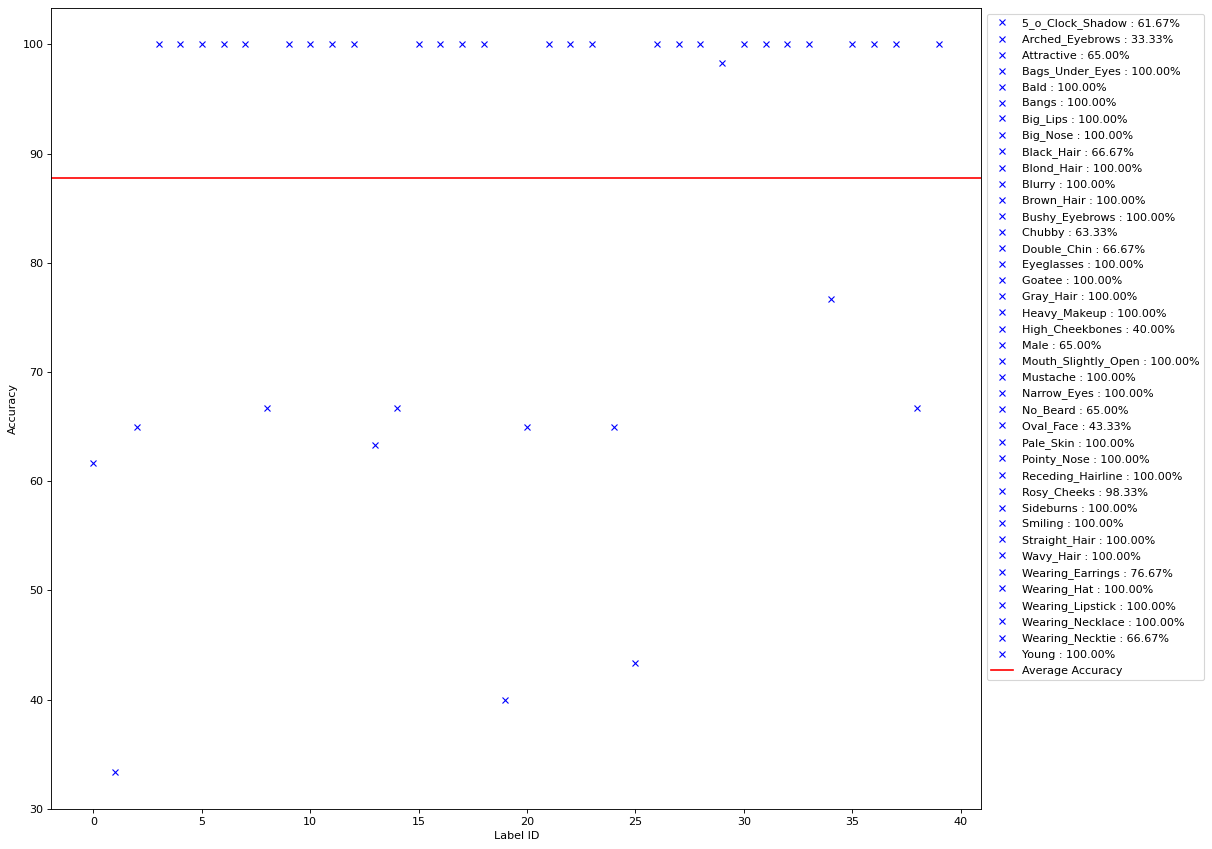

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 13), dpi=80, facecolor='w', edgecolor='k')

for idx, (label, score) in enumerate(class_accuracies.items()):
    plt.plot(idx, score, 'bx', label=f"{label} : {score:.2f}%")

plt.axhline(y=accuracy_test, color='r', linestyle='-', label='Average Accuracy')

plt.legend(loc='upper left', prop={'size': 10}, bbox_to_anchor=(1, 1), ncol=1)

plt.xlabel('Label ID')
plt.ylabel('Accuracy')

plt.show()

### Andamento dell'accuratezza e della perdita durante l'addestramento e la validazione.

#### Loss Graph

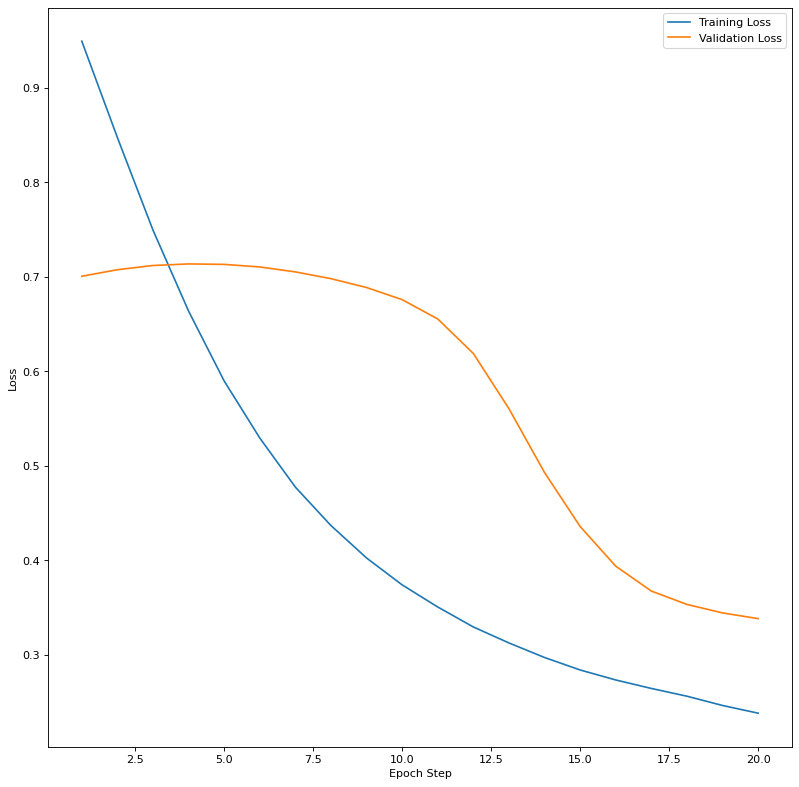

In [ ]:
import matplotlib.pyplot as plt
import pickle

# metriche del modello addestrato
with open('checkpoints/metrics.pkl', 'rb') as handle:
    training_losses, validation_losses, training_accuracies, validation_accuracies = pickle.load(handle)

plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

x_axis = list(range(1, len(training_losses) + 1))

plt.plot(x_axis, training_losses, label='Training Loss')
plt.plot(x_axis, validation_losses, label='Validation Loss')

plt.legend()

plt.xlabel('Epoch Step')
plt.ylabel('Loss')

plt.show()

#### Accuracies Graph

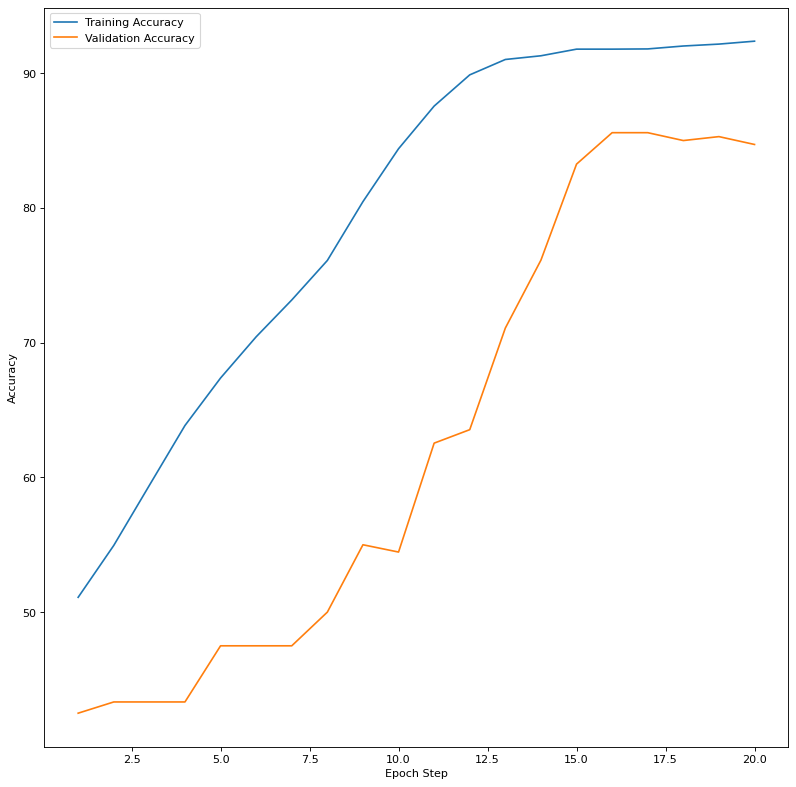

In [ ]:
import matplotlib.pyplot as plt
import pickle

with open('checkpoints/metrics.pkl', 'rb') as handle:
    training_losses, validation_losses, training_accuracies, validation_accuracies = pickle.load(handle)

plt.figure(figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')

x_axis = list(range(1, len(training_accuracies) + 1))

plt.plot(x_axis, training_accuracies, label='Training Accuracy')
plt.plot(x_axis, validation_accuracies, label='Validation Accuracy')

plt.legend()

plt.xlabel('Epoch Step')
plt.ylabel('Accuracy')

plt.show()